In [2]:
!pip install bayesian-optimization

In [3]:
import os
import cv2
import csv
import scipy
from scipy.io import loadmat,savemat
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

#from PIL import Image
import time
import random
import pandas as pd
from skimage.transform import resize
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import os.path
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense,AveragePooling1D,Flatten,TimeDistributed,Dropout

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

TensorFlow 2.x selected.


In [4]:
print(tf.version.VERSION)

2.1.0


In [0]:
def CreateDataList(TaskList):

    User_mouse_List = []
    User_cursor_List = []
    User_fixation_List = []


    for n in range(len(TaskList)):
        TaskName = TaskList[n]
        #print(TaskName)
        TaskListIndex = TaskList.index(TaskName)
        #print(TaskListIndex)
        ts_input_mouse = mat['guidata'][0][TaskListIndex][0][0][2][0][0][0][0]
        ts_input_cursor = mat['guidata'][0][TaskListIndex][0][0][2][0][0][3][0]
        ts_output_fixation = mat['guidata'][0][TaskListIndex][0][0][3][0]

# print(ts_output_fixation)

############################# Extract Timestamp , X and Y ########################################

############################## MOUSE ############################################
        Tmouse_List = []

        for k in ts_input_mouse:
            if k['event'][0][0][0] == "move" and k['type'][0][0] =='mouse':
#             # if k['timestamp'][0][0][0][0] not in Tmouse_dict:
#             #     Tmouse_dict[k['timestamp'][0][0][0][0]] = []
                    Tmouse_List.append((k['timestamp'][0][0][0][0], k['x'][0][0][0][0], k['y'][0][0][0][0]))

            # print(k.shape)
            # npInputArray = np.asarray(Tmouse_dict)
            # pd.DataFrame(npInputArray).to_csv("./Temporal_mouse.csv",  mode='a', header=None, index=None)
        User_mouse_List.append((Tmouse_List))
############################## CURSOR ############################################
        Tcursor_List = []

        for i in ts_input_cursor:
            if i['type'][0][0][0] == "caret":
                Tcursor_List.append((i['timestamp'][0][0][0][0], i['x'][0][0][0][0], i['y'][0][0][0][0]))

         # npInputArray = np.asarray(Tcursor_dict)
         # pd.DataFrame(npInputArray).to_csv("./Temporal_cursor.csv",  mode='a', header=None, index=None)
        User_cursor_List.append((Tcursor_List))
############################## FIXATION ############################################
        Tfixation_List = []
        X_thres_List = []
        Y_thres_List = []

        for i in ts_output_fixation:
            if i['event'][0][0][0] == "fixation":
                Tfixation_List.append((int(i['timestamp'][0][0][0][0]), int(i['x'][0][0][0]), int(i['y'][0][0][0])))


         # npInputArray = np.asarray(Tfixation_dict)
         # pd.DataFrame(npInputArray).to_csv("./Temporal_fixation.csv",  mode='a', header=None, index=None)

        # print(len(Tfixation_List), len(X_thres_List), len(Y_thres_List))
        User_fixation_List.append((Tfixation_List))

    return User_mouse_List, User_cursor_List, User_fixation_List

############################### NORMALIZE TIMESTAMP #################################################

def normalize(dataList):
    normTimeList = []
    min_time = dataList[0][0][0]
    max_time = dataList[-1][-1][0]
    #print(min_time, max_time)
    diff_time = max_time - min_time
    master_norm_List =[]

    for timeIter in dataList:
        #userIter = dataList[timeIter]
        normTimeList = []
        min_time = timeIter[0][0]
        max_time = timeIter[-1][0]
        diff_time = max_time - min_time

        for sublist in timeIter:
            norm_time = (sublist[0] - min_time)/ diff_time
            normTimeList.append([norm_time, sublist[1], sublist[2]])
        master_norm_List.append((normTimeList))

        # print(dataList[timeIter][sublist][0])



    return master_norm_List

############################### Threshold 0.1 times maximum value of Fixations ##############################
# def threshold(normTimeList, X_thres, Y_thres):
#     ThresTimeList = []
#
#
#     X_threshold =  int(X_thres)/10
#     Y_threshold = int(Y_thres)/10
#     print(X_threshold, Y_threshold)
#     for t in range(len(normTimeList)):
#         if int(normTimeList[t][1]) >= X_threshold:
#             thres_X = int(normTimeList[t][1])
#         if int(normTimeList[t][2]) >= Y_threshold:
#             thres_Y = int(normTimeList[t][2])
#             ThresTimeList.append((normTimeList[t][0], thres_X, thres_Y))
#
#     return ThresTimeList
########################### Interpolate and Sample 200 time points ############################################
def InterpolateSample(ThresTimeList):
    All_TimeValues = []


    for task in ThresTimeList:
        Time_values = []
        X_pos = []
        Y_pos = []
        for line in task:
            Time_values.append(line[0])
            X_pos.append(line[1])
            Y_pos.append(line[2])
        X_plot = interp1d(Time_values, X_pos, kind='linear')
        Y_plot = interp1d(Time_values, Y_pos, kind='linear')

        ######## Sampling 200 time points ###############20880
        TimeValues_new = np.linspace(0, 1, num=400)
        Pos_X_new = X_plot(TimeValues_new)
        Pos_Y_new = Y_plot(TimeValues_new)
        Final_sampled = [TimeValues_new, Pos_X_new, Pos_Y_new]
        All_TimeValues.append(Final_sampled)

    # plt.plot(Time_values, X_pos, 'o', TimeValues_new, Pos_X_new, '-')  ##### Plot interpolated X and Y with sampled time points
    # plt.title('Ground truth')
    # plt.xlabel('Normalised time')
    # plt.ylabel('x')
    # # plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
    # plt.show()

   # print('Shape interpolated:', np.shape(All_TimeValues))
    return All_TimeValues

In [6]:
# script_dir = os.path.dirname(os.path.abspath(__file__))
Mouse_block=[]
cursor_block =[]
Fixation_block=[]
Total_Interfaces = []
datasetdir = "/content/drive/My Drive/HCI/"
# listOfUsersMatFiles = ["Sampath.mat", "Somendra.mat", "Srikanth.mat", "Varun.mat"]
listOfUsersMatFiles = ["Alice.mat", "Charlotte.mat", "Irina.mat", "Konstantin.mat", "Lokesh.mat", "Mike.mat", "Russa.mat", "Sampath.mat", "Somendra.mat", "Srikanth.mat", "Varun.mat"]
import csv
for matfile in listOfUsersMatFiles:
    mat = scipy.io.loadmat(datasetdir + matfile)
    totalInterfaces_count = len(mat['guidata'][0])
    totalInterfaces = mat['guidata'][0]

    TaskList=[]
    print('Total Interfaces:', totalInterfaces_count)
    for i in range(totalInterfaces_count):
        TaskList.append(mat['guidata'][0][i][0][0][0][0])  # List of all tasks for User

    A_mouse , A_cursor, A_fixation = CreateDataList(TaskList)
    #print('MouseList:', len(A_mouse), 'Cursor:', len(A_cursor))

    ############################################# FUNCTION CALL NORMALIZATION ############################################
    norm_A_mouse = normalize(A_mouse)
    norm_A_cursor = normalize(A_cursor)
    norm_A_fixation = normalize(A_fixation)


    ############################################### FUNCTION CALL INTERPOLATION & SAMPLING ###############################
    NTS_A_mouse = InterpolateSample(norm_A_mouse)
    NTS_A_cursor = InterpolateSample(norm_A_cursor)
    NTS_A_fixation = InterpolateSample(norm_A_fixation)
    # window_size=30
    
    print(np.shape(NTS_A_mouse))
    # print('NTS_A_mouse:', np.shape(NTS_A_mouse))  ### totalInterfaces,3,400
    for i in range(totalInterfaces_count):
      # print(i)
      # for j in range(0,400):
      Mouse_block.append(np.concatenate((NTS_A_mouse[i][1]/1920, NTS_A_mouse[i][2]/1200)))
      cursor_block.append(np.concatenate((NTS_A_cursor[i][1]/1920, NTS_A_cursor[i][2]/1200)))
      Fixation_block.append(np.concatenate((NTS_A_fixation[i][1]/1920,NTS_A_fixation[i][2]/1200)))
      Total_Interfaces.append(totalInterfaces)

Mouse_block=np.array(np.reshape(Mouse_block,(245,2,400)))
cursor_block =np.array(np.reshape(cursor_block,(245,2,400)))
Fixation_block=np.array(np.reshape(Fixation_block,(245,2,400)))
Total_Interfaces=np.array(Total_Interfaces)

print(Mouse_block.shape)        
print(cursor_block.shape) 
print(Fixation_block.shape) 
print(Total_Interfaces.shape)      


    
    #     print('NTS_A_mouse:', np.shape(NTS_A_mouse))  ### totalInterfaces,3,400
    
    # for i in range(totalInterfaces):
    #     for j in range(400 - window_size ):
    #         #print('j for 20:', j)
    #         X_block.append(np.column_stack((NTS_A_mouse[i][1][j:j + window_size] / 1920.0,
    #                            NTS_A_cursor[i][1][j:j + window_size] / 1920.0,
    #                            NTS_A_mouse[i][2][j:j + window_size] / 1200.0,
    #                            NTS_A_cursor[i][2][j:j + window_size] / 1200.0)))

            
    #         Y_block.append(np.column_stack((NTS_A_fixation[i][1][j+window_size] / 1920.0,NTS_A_fixation[i][2][j+window_size] / 1200.0)))
            


Total Interfaces: 27
(27, 3, 400)
Total Interfaces: 28
(28, 3, 400)
Total Interfaces: 33
(33, 3, 400)
Total Interfaces: 27
(27, 3, 400)
Total Interfaces: 28
(28, 3, 400)
Total Interfaces: 25
(25, 3, 400)
Total Interfaces: 19
(19, 3, 400)
Total Interfaces: 7
(7, 3, 400)
Total Interfaces: 13
(13, 3, 400)
Total Interfaces: 19
(19, 3, 400)
Total Interfaces: 19
(19, 3, 400)
(245, 2, 400)
(245, 2, 400)
(245, 2, 400)
(245,)


In [0]:
def input_windowing(Mouse_block,cursor_block,Fixation_block,Total_interfaces,window_size):
  
  X_block=[]
  Y_block=[]
  data=[]
  label=[]
  # print('total interfaces from in window:',Total_Interfaces.shape[0])
  for i in range(Total_Interfaces.shape[0]):
    for j in range(400 - window_size ):
            #print('j for 20:', j)
      X_block.append(np.column_stack((Mouse_block[i][0][j:j + window_size],
                               cursor_block[i][0][j:j + window_size],
                               Mouse_block[i][1][j:j + window_size],
                               cursor_block[i][1][j:j + window_size])))

            
      Y_block.append(np.column_stack((Fixation_block[i][0][j+window_size],Fixation_block[i][1][j+window_size])))
  complete_data = np.array(X_block)
  complete_label = np.array(Y_block)
  complete_label= np.reshape(complete_label,(complete_label.shape[0],complete_label.shape[2]))
  # print('from function:',complete_data.shape)
  return complete_data,complete_label


In [0]:
#parameterbounds
hyperbounds={'window_size':(5,200), # possible[25,50,100,125,200,250,500] #discrete
'hiddenlayer1' : (50,200), #integer
'hiddenlayer2' :(50,200), #integer
'dropout1' :(0,0.5),}
# 'dropout2':(0,0.5),

#HyperParameters Dictionary

hyperparameters={'dropout1': 0.25, #  'dropout2': 0.36016224672107905, 
                 'hiddenlayer1': 100, 
                 'hiddenlayer2': 9,
                 'window_size': 20}


optimizer = BayesianOptimization(
    f=None,
    pbounds=hyperbounds,
    verbose=2,
    random_state=1,
)
  
utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

next_point_to_probe = optimizer.suggest(utility)


def discretize(hyperparamters):
  hyperparamters['window_size'] = int(hyperparamters['window_size'])
  # bounds= [40,30,20,10]
  # for bound in bounds:
  #   if(disc1>=bound):
  #     hyperparamters['window_size']=bound
  #     break
  
  hyperparamters['hiddenlayer1'] = int(hyperparamters['hiddenlayer1'])
  hyperparamters['hiddenlayer2'] = int(hyperparamters['hiddenlayer2'])
  # hyperparamters['hiddenlayer3'] = int(hyperparamters['hiddenlayer3'])
  return hyperparamters

optimizer.register(params=next_point_to_probe,target=0.0000,)   # target is validation loss

print(discretize(next_point_to_probe))

{'dropout1': 0.208511002351287, 'hiddenlayer1': 158, 'hiddenlayer2': 50, 'window_size': 63}


In [0]:
def model_optimization(Mouse_block,cursor_block,Fixation_block,interfaces,hyperparam):
  # print('complete data,label:1:',complete_data.shape,complete_label.shape)
  hyperparam=discretize(hyperparameters)
  win_data,win_label = input_windowing(Mouse_block,cursor_block,Fixation_block,interfaces,hyperparam['window_size'])
  # print(int(hyperparameters['window_size']))
  complete_data = np.array(win_data)
  complete_label = np.array(win_label)
  # print('complete data,label:2:',complete_data.shape[0],complete_label.shape)
  size=complete_data.shape[0]
  complete_ds=tf.data.Dataset.from_tensor_slices((complete_data,complete_label)).shuffle(size)
  # print('size:',size)
  train_size = int(0.7 * size)
  # train_ds = complete_ds.take(train_size).batch(50)
  # val_ds = complete_ds.skip(train_size).batch(50)
  # train_size = int(0.8 * 71060)
  train_ds = complete_ds.take(train_size).batch(size)
  # print('train size:',train_size)
  val_ds = complete_ds.skip(train_size).batch(size)
  model = Sequential()
  model.add(LSTM(hyperparam['hiddenlayer1'], input_shape=(hyperparam['window_size'], 4),return_sequences=True))
  model.add(Dropout(hyperparam['dropout1']))
  model.add(LSTM(hyperparam['hiddenlayer2']))
  model.add(Dense(2))
  model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), metrics=['accuracy'])
  print("model created")
  model.fit(train_ds, epochs=40, verbose=1,validation_data=val_ds,use_multiprocessing=True)
  return -sum(model.history.history['val_loss'][-10:])/10,model #return average of last 10 val accuracy
  #{'batch_size': 34, 'dropout1': 0.17101856696918327, 'dropout2': 0.029677076259280677, 'dropout3': 0.15900913585421567, 'epochs': 40, 'hiddenlayer1': 171, 'hiddenlayer2': 385, 'hiddenlayer3': 141, 'window_size': 250}

In [0]:
# hyperparam=discretize(hyperparameters)
# win_data,win_label = input_windowing(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,hyperparam['window_size'])
# # print(int(hyperparameters['window_size']))
# complete_data = np.array(win_data)
# complete_label = np.array(win_label)
# # print('complete data,label:2:',complete_data.shape[0],complete_label.shape)
# size=complete_data.shape[0]
# complete_ds=tf.data.Dataset.from_tensor_slices((complete_data,complete_label)).shuffle(size)
# # print('size:',size)
# # train_size = int(0.7 * size)
# # train_ds = complete_ds.take(train_size).batch(50)
# # val_ds = complete_ds.skip(train_size).batch(50)
# train_size = int(0.8 * 71060)
# train_ds = complete_ds.take(train_size).batch(size)
# # print('train size:',train_size)
# val_ds = complete_ds.skip(train_size).batch(size)
# model = Sequential()
# model.add(LSTM(hyperparam['hiddenlayer1'], input_shape=(hyperparam['window_size'], 4),return_sequences=True))
# model.add(Dropout(hyperparam['dropout1']))
# model.add(LSTM(hyperparam['hiddenlayer2']))
# model.add(Dense(2))
# model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), metrics=['accuracy'])
# print("model created")
# model.fit(train_ds, epochs=40, verbose=1,validation_data=val_ds,use_multiprocessing=True)


# print(-sum(model.history.history['val_loss'][-10:])/10)

In [0]:
#model.fit(train_ds, epochs=40, verbose=1,validation_data=val_ds,use_multiprocessing=True)
for _ in range(20):
    print(_)
    next_point = optimizer.suggest(utility)
    print((discretize(next_point)))
    target,newmodel = model_optimization(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,discretize(next_point))
    optimizer.register(params=next_point, target=target)
    
    print(target)
print('Optimizer max:',optimizer.max)


0
{'dropout1': 0.00385992799206053, 'hiddenlayer1': 43, 'hiddenlayer2': 80, 'window_size': 16}
model created
Train for 1 steps, validate for 1 steps
Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: 0.1931 - accuracy: 0.0293 - val_loss: 0.0947 - val_accuracy: 0.0277
Epoch 2/40
1/1 [==============================] - 1s 988ms/step - loss: 0.0952 - accuracy: 0.0286 - val_loss: 0.0540 - val_accuracy: 0.9723
Epoch 3/40
1/1 [==============================] - 1s 994ms/step - loss: 0.0546 - accuracy: 0.9689 - val_loss: 0.0395 - val_accuracy: 0.9726
Epoch 4/40
1/1 [==============================] - 1s 990ms/step - loss: 0.0401 - accuracy: 0.9723 - val_loss: 0.0411 - val_accuracy: 0.9716
Epoch 5/40
1/1 [==============================] - 1s 997ms/step - loss: 0.0419 - accuracy: 0.9729 - val_loss: 0.0431 - val_accuracy: 0.9717
Epoch 6/40
1/1 [==============================] - 1s 972ms/step - loss: 0.0436 - accuracy: 0.9719 - val_loss: 0.0407 - val_accuracy: 0.9744
Epoch 7/40
1/1

In [0]:
# next_point =  {'dropout1': 0.208511002351287, 'hiddenlayer1': 158.04867401632373, 'hiddenlayer2': 50.017156222601734, 'window_size': 63}
# print((discretize(next_point)))

# target,newmodel = model_optimization(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,discretize(next_point))

In [0]:
newmodel.summary()

In [0]:

print(optimizer.max)

{'target': 0.0, 'params': {'dropout1': 0.208511002351287, 'hiddenlayer1': 158.04867401632373, 'hiddenlayer2': 50.017156222601734, 'window_size': 63.95485166320876}}


In [0]:
##############################    change window size fro actual training ################################



# hyperparam=discretize(optimizer.max['params'])
window_size = 60
# win_data,win_label = input_windowing(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,(hyperparam['window_size']))
win_data,win_label = input_windowing(Mouse_block,cursor_block,Fixation_block,Total_Interfaces,window_size)
# print(int(hyperparameters['window_size']))
complete_data = np.array(win_data)
complete_label = np.array(win_label)
# print('complete data,label:2:',complete_data.shape[0],complete_label.shape)
size=complete_data.shape[0]
complete_ds=tf.data.Dataset.from_tensor_slices((complete_data,complete_label)).shuffle(size)
print('size:',size)
# train_size = int(0.7 * size)
# train_ds = complete_ds.take(train_size).batch(50)
# val_ds = complete_ds.skip(train_size).batch(50)
# train_size = int(0.8 * 71060)
train_size = int(0.8*70380)
# train_size = int(0.8 * 80730)
train_ds = complete_ds.take(train_size).batch(window_size)
print('train size:',train_size)
val_ds = complete_ds.skip(train_size).batch(window_size)


size: 83300
train size: 56304


In [0]:
# model = Sequential()
# model.add(LSTM(hyperparam['hiddenlayer1'], input_shape=(hyperparam['window_size'], 4),return_sequences=True))
# model.add(Dropout(hyperparam['dropout1']))
# model.add(LSTM(hyperparam['hiddenlayer2']))
# model.add(Dense(2))
# model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), metrics=['accuracy'])
# print("model created")
# model.summary()

In [0]:
model = Sequential()
model.add(LSTM(158, input_shape=(window_size, 4),return_sequences=True))
model.add(Dropout(0.2085))
model.add(LSTM(50))
model.add(Dense(2))
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), metrics=['accuracy'])
print("model created")
model.summary()

model created
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_124 (LSTM)              (None, 60, 158)           103016    
_________________________________________________________________
dropout_62 (Dropout)         (None, 60, 158)           0         
_________________________________________________________________
lstm_125 (LSTM)              (None, 50)                41800     
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 102       
Total params: 144,918
Trainable params: 144,918
Non-trainable params: 0
_________________________________________________________________


In [0]:

M = model.fit(train_ds, epochs=40, verbose=1,validation_data=val_ds,use_multiprocessing=True)

Train for 939 steps, validate for 450 steps
Epoch 1/40
939/939 [==============================] - 17s 18ms/step - loss: 0.0079 - accuracy: 0.8794 - val_loss: 0.0069 - val_accuracy: 0.8865
Epoch 2/40
939/939 [==============================] - 14s 15ms/step - loss: 0.0067 - accuracy: 0.8866 - val_loss: 0.0070 - val_accuracy: 0.8911
Epoch 3/40
939/939 [==============================] - 14s 15ms/step - loss: 0.0066 - accuracy: 0.8901 - val_loss: 0.0065 - val_accuracy: 0.8986
Epoch 4/40
939/939 [==============================] - 14s 15ms/step - loss: 0.0063 - accuracy: 0.8948 - val_loss: 0.0068 - val_accuracy: 0.8925
Epoch 5/40
939/939 [==============================] - 14s 15ms/step - loss: 0.0061 - accuracy: 0.8973 - val_loss: 0.0063 - val_accuracy: 0.8892
Epoch 6/40
939/939 [==============================] - 14s 15ms/step - loss: 0.0060 - accuracy: 0.8994 - val_loss: 0.0059 - val_accuracy: 0.9030
Epoch 7/40
939/939 [==============================] - 14s 15ms/step - loss: 0.0058 - accurac

In [0]:
############################# PREDICTIONS #######################
N_train_val = 70380

test_data = complete_data[N_train_val:size]
print('Test data:', test_data.shape)
test_label = complete_label[N_train_val:size]
print('Test label:', test_label.shape)



l_X = []
Mouse_X = []
cursor_X = []
Fix_X = []
l_Y = []
Mouse_Y = []
cursor_Y = []
Fix_Y = []

test_ds = np.reshape(test_data,(size-N_train_val,window_size,4))

l=model.predict(test_ds)

for check in range((size-N_train_val)):
    Mouse_X.append(test_data[check][59][0]*1920)
    cursor_X.append(test_data[check][59][1]*1920)
    Fix_X.append(test_label[check][0]*1920)
    l_X.append(l[check][0]*1920)
    Mouse_Y.append(test_data[check][59][2]*1200)
    cursor_Y.append(test_data[check][59][3]*1200)
    Fix_Y.append(test_label[check][1]*1200)
    l_Y.append(l[check][1]*1200)
      

Test data: (12920, 60, 4)
Test label: (12920, 2)


In [0]:
print(l_X[12919:12920],l_Y[12919:12920])
print(Fix_X[12919:12920],Fix_Y[12919:12920])
print(Mouse_X[12919:12920],Mouse_Y[12919:12920])
print(cursor_X[12919:12920],cursor_Y[12919:12920])


[1244.842529296875] [511.65668964385986]
[1397.0] [257.0]
[1385.0] [285.61152882205556]
[733.0079942940351] [247.3502233845484]


In [0]:
Mouse_X =np.array(Mouse_X)
cursor_X =np.array(cursor_X)
Fix_X=np.array(Fix_X)
l_X=np.array(l_X)

Mouse_Y =np.array(Mouse_Y)
cursor_Y =np.array(cursor_Y)
Fix_Y=np.array(Fix_Y)
l_Y=np.array(l_Y)

In [0]:
print(size-N_train_val)

pd.DataFrame(cursor_X).to_csv("./nbo_cursor_XX_12920.csv",  mode='a', header=None, index=None)
pd.DataFrame(Mouse_X).to_csv("./nbo_mouse_XX_12920.csv",  mode='a', header=None, index=None)
pd.DataFrame(l_X).to_csv("./nbo_prediction_XX_12920.csv",  mode='a', header=None, index=None)

pd.DataFrame(cursor_Y).to_csv("./nbo_cursor_YY_12920.csv",  mode='a', header=None, index=None)
pd.DataFrame(Mouse_Y).to_csv("./nbo_mouse_YY_12920.csv",  mode='a', header=None, index=None)
pd.DataFrame(l_Y).to_csv("./nbo_prediction_YY_12920.csv",  mode='a', header=None, index=None)

pd.DataFrame(Fix_X).to_csv("./nbo_GT_Fix_XX_12920.csv",  mode='a', header=None, index=None)
pd.DataFrame(Fix_Y).to_csv("./nbo_GT_Fix_YY_12920.csv",  mode='a', header=None, index=None)

12920


In [0]:
# print(Total_Interfaces[0:,])
## Dict: {"Alice.mat":27,"Charlotte.mat":28, "Irina.mat":33, "Konstantin.mat":27, "Lokesh.mat":28, "Mike.mat":25, "Russa.mat":19, "Sampath.mat":7, "Somendra.mat":13, "Srikanth.mat":19, "Varun.mat":19}

#Train,Validate: 207(tasks)*337(datapoints) = 69759
#Test: 38*337 = 12806

# N_train_val = 69759

In [0]:
# size=complete_data.shape[0]
# complete_ds=tf.data.Dataset.from_tensor_slices((complete_data,complete_label)).shuffle(size)
# # print('size:',size)
# # train_size = int(0.7 * size)
# # train_ds = complete_ds.take(train_size).batch(50)
# # val_ds = complete_ds.skip(train_size).batch(50)

# train_size = int(0.8 * N_train_val)
# train_ds = complete_ds.take(train_size).batch(size)
# # print('train size:',train_size)
# val_ds = complete_ds.skip(train_size).batch(size)
test_ds = np.reshape(complete_data[train_size:size],(size-train_size,10,4))

In [1]:
############## PLOT ###################

plt.plot(M.history["loss"])
plt.plot(M.history["val_loss"])
# plt.plot(M.history["val_accuracy"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.savefig('Model_loss.png')
plt.show()

NameError: ignored

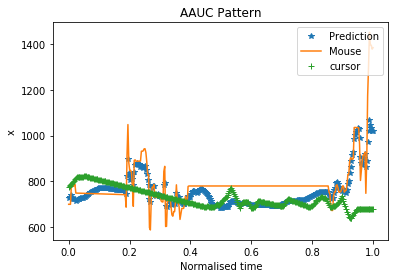

In [0]:
######                        TEMPORAL                    ###############
Time_values = np.linspace(0, 1, num=340)
########### Split tasks 1 users to plot ####################
###############
# plt.plot(Time_values,Fix_X[0:380],'+')  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,l_X[0:340], '*')  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[0:340],'-')  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,cursor_X[0:340],'+')

plt.title('AAUC Pattern')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Prediction", "Mouse","cursor"], loc="upper right") #, "Prediction"]''')
# plt.savefig('AAUC_pred.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

In [0]:
Mouse_X[0]

699.9064516835508

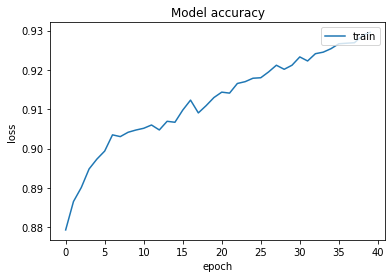

In [0]:

# plt.plot(M.history["val_accuracy"])
plt.plot(M.history["accuracy"])
plt.title("Model accuracy")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

In [0]:
pred_X_Y = np.vstack((l_X[760:1140], l_Y[760:1140].T))
gt_X_Y = np.vstack((Fix_X[760:1140], Fix_Y[760:1140].T))
mouse_X_Y = np.vstack((Mouse_X[760:1140], Mouse_Y[760:1140].T))

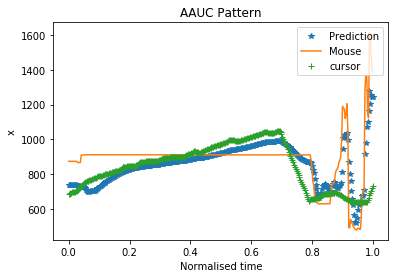

In [0]:
######                        TEMPORAL                    ###############
Time_values = np.linspace(0, 1, num=340)
########### Split tasks 1 users to plot ####################
###############
# plt.plot(Time_values,Fix_X[0:340],'+')  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,l_X[12580:12920], '*')  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[12580:12920],'-')  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,cursor_X[12580:12920],'+')

plt.title('AAUC Pattern')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Prediction", "Mouse","cursor"], loc="upper right") #, "Prediction"]''')
# plt.savefig('AAUC_pred.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

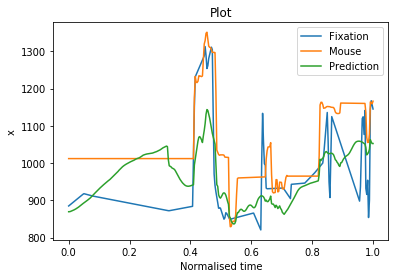

In [0]:
######                        TEMPORAL                    ###############
###### Split tasks 2 users to plot ####################
plt.plot(Time_values,Fix_X[340:680])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[340:680])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,l_X[340:680])  ##### Plot interpolated X and Y with sampled time points
plt.title('Plot')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Fixation", "Mouse", "Prediction"], loc="upper right")
# plt.savefig('Sampath_task2.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

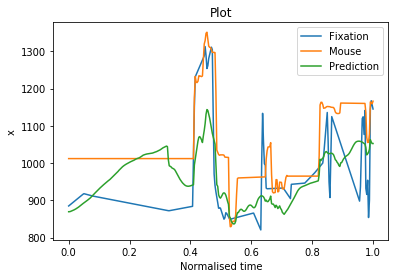

In [0]:
###### Split tasks 2 users to plot ####################
plt.plot(Time_values,Fix_X[340:680])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[340:680])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,l_X[340:680])  ##### Plot interpolated X and Y with sampled time points
plt.title('Plot')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Fixation", "Mouse", "Prediction"], loc="upper right")
# plt.savefig('Sampath_task2.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

In [0]:
######                        TEMPORAL                    ###############
###### Split tasks 3 users to plot ####################
plt.plot(Time_values,Fix_X[760:1140])  ##### FIXATION
plt.plot(Time_values,Mouse_X[760:1140])  ##### MOUSE
plt.plot(Time_values,cursor_X[760:1140])  ##### CURSOR
# plt.plot(Time_values,l_X[760:1140])  ##### PREDICTION
plt.title('Plot')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Fixation", "Mouse","Cursor"])#, "Prediction"], loc="upper right")
plt.savefig('Sampath_task7.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

In [0]:
######                        TEMPORAL                    ###############
###### Split tasks 3 users to plot ####################
plt.plot(Time_values,Fix_X[2280:2660])  ##### FIXATION
plt.plot(Time_values,Mouse_X[2280:2660])  ##### MOUSE
plt.plot(Time_values,cursor_X[2280:2660])  ##### CURSOR
# plt.plot(Time_values,l_X[2280:2660])  ##### PREDICTION
plt.title('Plot')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Fixation", "Mouse","Cursor", "Prediction"], loc="upper right")
plt.savefig('Sampath_task7.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

ValueError: ignored

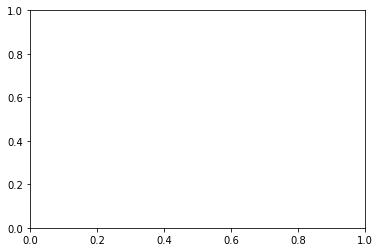

In [0]:
######                        TEMPORAL                    ###############
###### Split tasks 4 users to plot ####################
plt.plot(Time_values,Fix_X[1140:1520])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,Mouse_X[1140:1520])  ##### Plot interpolated X and Y with sampled time points
plt.plot(Time_values,l_X[1140:1520])  ##### Plot interpolated X and Y with sampled time points
plt.title('Plot')
plt.xlabel('Normalised time')
plt.ylabel('x')
plt.legend(["Fixation", "Mouse", "Prediction"], loc="upper right")
plt.savefig('Sampath_task4.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

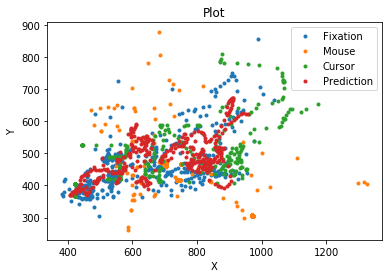

In [0]:
######                   SPATIAL                    ###############
window1 = 1140
window2 = 1520

plt.plot(Fix_X[window1:window2],Fix_Y[window1:window2],'.')  ##### Plot GROUND TRUTH
plt.plot(Mouse_X[window1:window2],Mouse_Y[window1:window2],'.')  ##### Plot MOUSE
plt.plot(cursor_X[window1:window2],cursor_Y[window1:window2],'.')  ##### Plot CURSOR
plt.plot(l_X[window1:window2],l_Y[window1:window2],'.')  ##### Plot PREDICTION
plt.title('Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(["Fixation", "Mouse", "Cursor", "Prediction"], loc="upper right")
# plt.savefig('Sampath_task2_space.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()

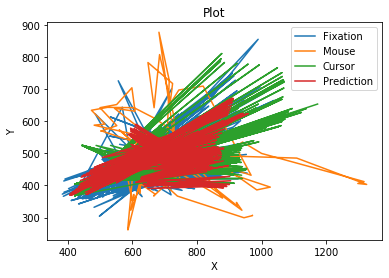

In [0]:
######                   SPATIAL                    ###############
plt.plot(Fix_X[1140:1520],Fix_Y[1140:1520])  ##### Plot GROUND TRUTH
plt.plot(Mouse_X[1140:1520],Mouse_Y[1140:1520])  ##### Plot MOUSE
plt.plot(cursor_X[1140:1520],cursor_Y[1140:1520])  ##### Plot CURSOR
plt.plot(l_X[1140:1520],l_Y[1140:1520])  ##### Plot PREDICTION
plt.title('Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(["Fixation", "Mouse", "Cursor", "Prediction"], loc="upper right")
# plt.savefig('Sampath_task4_space.png')
# plt.plot(Time_values, Y_pos, 'o', TimeValues_new, Pos_Y_new, '-')
plt.show()